In [ ]:
#Import libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from sklearn.metrics import   confusion_matrix, ConfusionMatrixDisplay , classification_report
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#unzip folder
!unzip -uq /content/drive/MyDrive/Train-Val-Test-Split-Dataset.zip

In [ ]:
#Parameters
BATCH_SIZE= 32
EPOCHS = 10
IMG_HEIGHT= 300 
IMG_WIDTH= 300

In [ ]:
#Data augmentation
train_dir= '/content/Train-Val-Test-Split-Dataset/train'
val_dir= '/content/Train-Val-Test-Split-Dataset/val'
test_dir= '/content/Train-Val-Test-Split-Dataset/test'

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
train_datagen= ImageDataGenerator(rescale= 1/255., 
                                  rotation_range= 40, 
                                  width_shift_range=0.2, 
                                  height_shift_range= 0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2, 
                                  horizontal_flip= True, 
                                  preprocessing_function= preprocess_input, 
                                  fill_mode= 'nearest')

val_datagen= ImageDataGenerator(rescale=1/255., preprocessing_function= preprocess_input)

training_generator= train_datagen.flow_from_directory(train_dir, 
                                                      batch_size= BATCH_SIZE, 
                                                      class_mode= 'binary',
                                                      color_mode= 'rgb', 
                                                      seed= 42,
                                                      target_size= (IMG_HEIGHT,IMG_WIDTH)) 

validation_generator= val_datagen.flow_from_directory(val_dir, 
                                                      batch_size= BATCH_SIZE, 
                                                      class_mode= 'binary', 
                                                      color_mode= 'rgb',
                                                      seed= 42,
                                                      shuffle=False,
                                                      target_size= (IMG_HEIGHT,IMG_WIDTH)) 

test_generator= val_datagen.flow_from_directory(test_dir, 
                                                 batch_size= BATCH_SIZE, 
                                                 class_mode= 'binary',
                                                color_mode= 'rgb',
                                                shuffle=False, 
                                                 seed= 42,
                                                 target_size= (IMG_HEIGHT,IMG_WIDTH)) 



Found 3565 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


In [ ]:
#define feature extraction layer
def feature_extraction(inputs):
    feature_extractor= tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
                                                            include_top= False,
                                                            weights= 'imagenet')(inputs)
    return feature_extractor

#define classifier layer
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    #x= tf.keras.layers.Dropout(0.3) (x)
    x = tf.keras.layers.Dense(512, activation= 'relu')(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid", name="classification")(x)
    
    return x


#define final model
def final_model(inputs):
    inception_feature_extractor= feature_extraction(inputs)
    classification_output= classifier(inception_feature_extractor)
    
    return classification_output

#define the model and compile it
def define_and_compile_model():
    inputs= tf.keras.layers.Input(shape= (IMG_HEIGHT,IMG_WIDTH,3))
    classification_output= final_model(inputs)
    classification_output.trainable= True
    model= tf.keras.Model(inputs= inputs, outputs= classification_output)

    model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss= 'binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
#print model
model = define_and_compile_model()
model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 classification (Dense)      (None, 1)                 513       
                                                                 
Total params: 22,852,385
Trainable params: 22,817,953
Non-trai

In [ ]:
checkpoint_filepath = '/content/checkpoint.h5'

#Create checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         mode='max',
                                                         save_best_only=True)

#Reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.2,
                                                patience=3,
                                                 min_lr= 0.001,
                                                 verbose=1)

#stop training if model's val_loss doesn't improve for 5 epochs
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True)

#Early stoping
#class myCallback(tf.keras.callbacks.Callback):
  #def on_epoch_end(self, epoch, log={}):
    #if log.get('accuracy') >= 98:
      #self.model.stop_training= True 

#earlyStoppingCallback= myCallback()

In [ ]:
#Train the model
history= model.fit( training_generator, 
                   validation_data= validation_generator,  
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS, 
                   callbacks= [checkpoint_callback,
                               reduce_lr,
                               earlyStoppingCallback])

Epoch 1/10
112/112 [==============================] - 164s 1s/step - loss: 0.0413 - accuracy: 0.9846 - val_loss: 0.0835 - val_accuracy: 0.9756 - lr: 0.0100
Epoch 2/10
112/112 [==============================] - 162s 1s/step - loss: 0.0397 - accuracy: 0.9846 - val_loss: 0.0836 - val_accuracy: 0.9778 - lr: 0.0100
Epoch 3/10
112/112 [==============================] - 163s 1s/step - loss: 0.0377 - accuracy: 0.9863 - val_loss: 0.0788 - val_accuracy: 0.9733 - lr: 0.0100
Epoch 4/10
112/112 [==============================] - 163s 1s/step - loss: 0.0320 - accuracy: 0.9891 - val_loss: 0.0851 - val_accuracy: 0.9733 - lr: 0.0100
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9899
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
112/112 [==============================] - 163s 1s/step - loss: 0.0293 - accuracy: 0.9899 - val_loss: 0.0894 - val_accuracy: 0.9733 - lr: 0.0100
Epoch 6/10
112/112 [==============================] - 162s 

In [ ]:
def plot_loss_acc(history):
  plt.plot(history.history["loss"], label="training_loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(history.history["accuracy"], label="training_accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

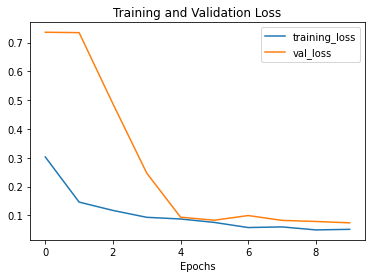

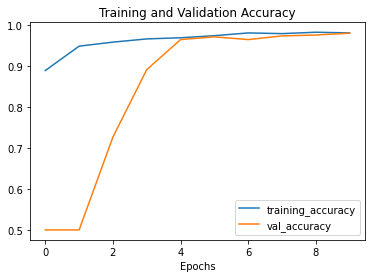

In [ ]:
# Plot training results
plot_loss_acc(history)

In [ ]:
#model evaluation
results= model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06306
Test Accuracy: 97.78%


In [ ]:
#classification report
predictions = model.predict(test_generator)
y_pred= [1 if i >= 0.5 else 0 for i in predictions]

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels ))

15/15 [==============================] - 11s 696ms/step
              precision    recall  f1-score   support

      Cracks       0.98      0.97      0.98       225
      Groove       0.97      0.98      0.98       225

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



<Figure size 864x432 with 0 Axes>

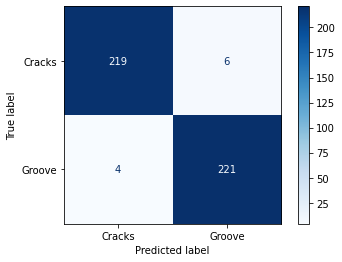

In [ ]:
#confusion matrix
plt.figure(figsize= (12,6))
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
#save & download model 
model.save("InceptionV3.h5")
files.download("InceptionV3.h5")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>